In [1]:
import cv2
import random
import csv as csv
import numpy as np
import pandas as pd
import scipy.spatial.distance
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from pylab import *
from PIL import Image
from skimage.feature import hog, local_binary_pattern
from skimage import data, color, exposure
from skimage.color import label2rgb
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

%matplotlib inline

/Users/michellechen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [3]:
# Draw pictures by result ranking

def plot_results(res):
    """ Show images in result list 'res'. """
    figure()
    nbr_results = len(res)
    for i in range(nbr_results):
        subplot(1,nbr_results,i+1)
        imshow(array(Image.open(res[i])))
        axis('off')
    show()

In [4]:
# Get image's LBP 

def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)

def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')
        
def hist(ax, lbp):
    n_bins = lbp.max() + 1
    return ax.hist(lbp.ravel(), normed=True, bins=n_bins, range=(0, n_bins), facecolor='0.5')

def GET_LBP(im_path):
    radius = 2
    n_points = 8 * radius
    METHOD = 'uniform'
    image = cv2.imread(im_path, 0)
    lbp = local_binary_pattern(image, n_points, radius, METHOD)
    lbp = lbp.reshape(218*255) # Reshape to one dimension
    return lbp

In [5]:
# Get image's HOG

def GET_HOG(im_path):
    image = cv2.imread(im_path, 0)
    image = color.rgb2gray(image)
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(32, 32), cells_per_block=(1, 1), visualise=True)
    hog_image = hog_image.reshape(218*255) # Reshape to one dimension
    return hog_image

In [6]:
# Get image's Color Histogram

def GET_COLOR(im_path):
    image = cv2.imread(im_path)
    # Calculate query image's color histogram by cv2 and show it
    #hist = cv2.calcHist([image],[0],None,[256],[0,256])
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist).flatten()
    return hist

In [7]:
# Get all clothing images' LBP and HOG features and combine them to an one dimension feature

im_path = []
im_COLOR = []
im_LBP = []
im_HOG = []
im_feature = []

for i in xrange(942):
    
    im_path.append('clothing_image/' + str(i+1) + '.jpg')
    
    im_COLOR.append(GET_COLOR(im_path[i]))
    #print "image" + str(i+1) + "'s Color Histogram:"
    #print im_COLOR[i]
    
    im_LBP.append(GET_LBP(im_path[i]))
    #print "image" + str(i+1) + "'s LBP:"
    #print im_LBP[i]

    im_HOG.append(GET_HOG(im_path[i]))
    #print "image" + str(i+1) + "'s HOG:"
    #print im_HOG[i]
    
    # Comebine Color Histogram, LBP, HOG to an one dimensional feature
    im_feature.append(np.append(np.append(im_COLOR[i], im_LBP[i]), im_HOG[i]))
    #im_feature.append(np.append(im_COLOR[i], im_HOG[i]))
    print "image" + str(i+1) + "'s feature:"
    print im_feature[i]
    

image1's feature:
[  2.20031734e-03   3.33381431e-05   0.00000000e+00 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
image2's feature:
[ 0.00010238  0.          0.         ...,  0.          0.          0.        ]
image3's feature:
[ 0.  0.  0. ...,  0.  0.  0.]
image4's feature:
[ 0.52653968  0.00058012  0.         ...,  0.          0.          0.        ]
image5's feature:
[  6.38551952e-04   9.12217074e-05   0.00000000e+00 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
image6's feature:
[  6.78007418e-05   7.45808182e-04   0.00000000e+00 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
image7's feature:
[ 0.14290565  0.10887904  0.         ...,  0.          0.          0.        ]
image8's feature:
[  3.59788653e-04   6.54161195e-05   0.00000000e+00 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
image9's feature:
[ 0.17694283  0.03160932  0.         ...,  0.          0.          0.        ]
image10's feature:
[ 0.  0.  0. ...,  0.  0.  0.]
i

In [8]:
# Positive pair data

pair_df = pd.read_csv('PAIR.csv')

print pair_df

      pairA  pairB
0         1    158
1         1    502
2         2    158
3         2    502
4         3    624
5         3    123
6         3    166
7         4    123
8         4    624
9         4    166
10        5    166
11        5    624
12        5    123
13        6    119
14        6    717
15        7    119
16        7    717
17        8    118
18        8     37
19        8    232
20        8    578
21        9      4
22       10      4
23       25    145
24       26    145
25       27    620
26       29    125
27       29    125
28       29    717
29       29     96
...     ...    ...
1892    921    578
1893    921    919
1894    922    886
1895    922    918
1896    922    941
1897    923    941
1898    923    886
1899    923    918
1900    924    923
1901    924    922
1902    927    169
1903    928    644
1904    930    689
1905    930    697
1906    931    918
1907    931    113
1908    932     97
1909    932    118
1910    932     88
1911    932     97
1912    933 

In [9]:
# Using random sample to generate negative pair data

import random

item = []
for i in xrange(942):
    item.append(i+1)

notpair = []
for i in xrange(1922):
    notpair.append(random.sample(item, 2))
    print notpair[i]

[501, 88]
[753, 280]
[224, 857]
[203, 50]
[616, 114]
[265, 67]
[383, 703]
[586, 343]
[383, 806]
[705, 660]
[922, 686]
[737, 72]
[504, 850]
[647, 569]
[390, 862]
[187, 709]
[25, 850]
[131, 655]
[734, 501]
[554, 148]
[70, 492]
[884, 398]
[583, 72]
[509, 845]
[219, 884]
[25, 247]
[893, 206]
[554, 618]
[412, 622]
[485, 801]
[311, 46]
[670, 858]
[584, 717]
[932, 879]
[552, 685]
[829, 194]
[204, 847]
[715, 796]
[259, 434]
[399, 178]
[705, 492]
[130, 16]
[599, 490]
[140, 525]
[579, 470]
[96, 844]
[182, 448]
[395, 12]
[205, 603]
[853, 876]
[491, 695]
[260, 484]
[820, 910]
[681, 594]
[921, 414]
[22, 415]
[720, 310]
[891, 828]
[764, 243]
[691, 35]
[414, 329]
[334, 440]
[756, 940]
[895, 507]
[701, 521]
[737, 872]
[213, 56]
[30, 137]
[676, 201]
[211, 462]
[925, 464]
[265, 470]
[14, 431]
[93, 912]
[918, 495]
[48, 208]
[767, 60]
[14, 500]
[848, 859]
[510, 191]
[809, 749]
[842, 806]
[531, 849]
[503, 154]
[442, 535]
[741, 865]
[416, 495]
[567, 502]
[698, 521]
[746, 487]
[99, 368]
[162, 468]
[777, 449]

In [10]:
# Combine the feature of pair images

pair_feature = []
notpair_feature = []

for i in xrange(1922):
    pairA = pair_df.values[i][0]
    pairB = pair_df.values[i][1]
    pairC = notpair[i][0]
    pairD = notpair[i][1]
    pair_feature.append(np.append(im_feature[pairA-1], im_feature[pairB-1]))
    notpair_feature.append(np.append(im_feature[pairC-1], im_feature[pairD-1]))
    
    print "pair" + str(i+1) + "'s feature:"
    print pair_feature[i]
    print "notpair" + str(i+1) + "'s feature:"
    print notpair_feature[i]

pair1's feature:
[  2.20031734e-03   3.33381431e-05   0.00000000e+00 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
notpair1's feature:
[ 0.  0.  0. ...,  0.  0.  0.]
pair2's feature:
[  2.20031734e-03   3.33381431e-05   0.00000000e+00 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
notpair2's feature:
[ 0.00237241  0.00021567  0.         ...,  0.          0.          0.        ]
pair3's feature:
[ 0.00010238  0.          0.         ...,  0.          0.          0.        ]
notpair3's feature:
[ 0.  0.  0. ...,  0.  0.  0.]
pair4's feature:
[ 0.00010238  0.          0.         ...,  0.          0.          0.        ]
notpair4's feature:
[ 0.  0.  0. ...,  0.  0.  0.]
pair5's feature:
[ 0.  0.  0. ...,  0.  0.  0.]
notpair5's feature:
[ 0.  0.  0. ...,  0.  0.  0.]
pair6's feature:
[ 0.  0.  0. ...,  0.  0.  0.]
notpair6's feature:
[ 0.07096586  0.          0.         ...,  0.          0.          0.        ]
pair7's feature:
[ 0.  0.  0. ...,  0.  0.  0.]
notpair7

In [11]:
# All the positive pair and negative pair, store with their feature
allpair_feature = pair_feature + notpair_feature 

print len(allpair_feature), len(allpair_feature[0])

3844 223384


In [12]:
# Training data (500 of positive and 500 of negative)
X = pair_feature[0:500] + notpair_feature[0:500]
X = np.array(X)

In [13]:
# Truth of training data
Y = []
for i in xrange(500):
    Y.append(1)
for i in xrange(500):
    Y.append(0)
Y = np.array(Y)

In [14]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [15]:
from sklearn.svm import SVC
estimator = SVC(kernel='linear')

In [16]:
from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2, random_state=0)

In [17]:
from sklearn.grid_search import GridSearchCV
import numpy as np
gammas = np.logspace(-6, -1, 10)
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=dict(gamma=gammas))
classifier.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(800, n_iter=10, test_size=0.2, random_state=0),
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'gamma': array([  1.00000e-06,   3.59381e-06,   1.29155e-05,   4.64159e-05,
         1.66810e-04,   5.99484e-04,   2.15443e-03,   7.74264e-03,
         2.78256e-02,   1.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

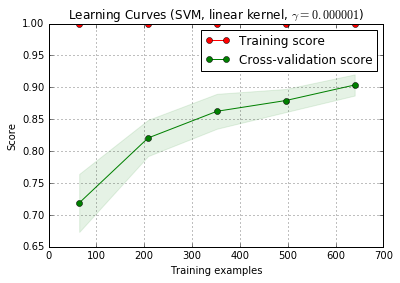

In [18]:
from sklearn.learning_curve import learning_curve
title = 'Learning Curves (SVM, linear kernel, $\gamma=%.6f$)' %classifier.best_estimator_.gamma
estimator = SVC(kernel='linear', gamma=classifier.best_estimator_.gamma)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv)
plt.show()

Automatically created module for IPython interactive environment


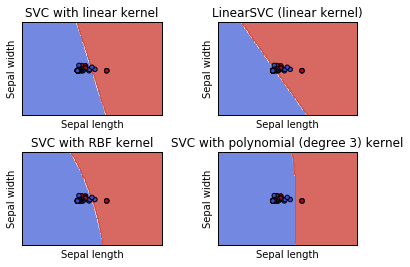

In [41]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

# import some data to play with
#X = X[:, :2]  # we only take the first two features. We could
                # avoid this ugly slicing by using a two-dim dataset
X = X[:, :2]   
y = Y
h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()